# EDA - Crime statistics in Poland between the years 1999-2021

The following project is to test exploratory data analysis techniques.<br>
Data originates from an open public repository maintained by the Polish government - [dane.gov.pl](https://dane.gov.pl) <br>
Data used in this project were collected by the police. They contain information about crimes and offences committed in Poland. <br>
Labels and column names needed to be translated into English to reach a wider audience.

In [1]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import colorcet as cc

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
path = r'./data/raw/Dane_o_przestepczosci_w_latach_19992021/'  # path for data import
viz_path = r'./src/visualization/'  # path to save visualisations

In [2]:
"""
This fragment was used to trim folder names in data imported from public repository.
It should be only run once on freshly unpacked data.
""";

# for (dirpath, dirnames, filenames) in os.walk(path):
#     for filename in filenames:
#         re1 = r'^(.*?) wg'
#         re2 = '([^\/]+$)'
#         cutname = re.compile("(%s|%s)" % (re1, re2)).findall(dirpath)
#
#         if not (exists(cutname[0][1])):
#             os.rename(dirpath, cutname[0][1])
#         else:
#             os.rename(dirpath, cutname[0][1] + " cd")

## Data loading and improving readability

Only some folders in the dataset contain information that could fit into this analysis.
Folders with the most common crimes for each voivodeship and for Warsaw were collected.

In [3]:
crimes = pd.DataFrame()
for (dirpath, dirnames, filenames) in os.walk(path):  # loading selected crimes statistics into the dataframe
    for filename in filenames:
        if re.search("przestepstwa", filename) is not None:
            crime = re.findall(r"(?<=_)\w+", filename)
            df_name = pd.read_csv(r"{}".format(dirpath + "/" + filename), sep=';', skiprows=2, usecols=[*range(0, 4)],
                                  encoding='cp1250')
            df_name['type'] = str(crime[0])
            crimes = pd.concat([crimes, df_name], ignore_index=True)

crimes = crimes.dropna()
crimes = crimes.rename(columns={'Jednostka podziału administracyjnego': 'area', 'Rok': 'year',
                                'Przestępstwa stwierdzone': 'confirmed_crimes',
                                'Przestępstwa wykryte': 'detected_crimes'})  # renaming columns to english

crimes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6118 entries, 0 to 6160
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   area              6118 non-null   object 
 1   year              6118 non-null   float64
 2   confirmed_crimes  6118 non-null   object 
 3   detected_crimes   6118 non-null   object 
 4   type              6118 non-null   object 
dtypes: float64(1), object(4)
memory usage: 286.8+ KB


A quick peek into the Crimes dataframe shows there are no null values to be deleted or replaced.

Explanation of the difference between confirmed and detected crimes[^1]:
A confirmed crime is an event confirmed as a crime in the completed preparatory proceedings. If in the completed proceedings, it was found that the event did not have the characteristics of a crime, it is not subject to statistical registration.
A detected crime is a confirmed crime in which at least one suspect has been identified and proven to have committed the crime in the completed preparatory proceedings.

[^1]: [Source](http://bip.katowice.kwp.policja.gov.pl/KWK/stan-bezpieczenstwa/294,Stan-bezpieczenstwa.html)

In [4]:
"""
Crimes translations
"""
eng_names = {'kradziez': 'theft', 'kradziez_samochodu': 'car theft', 'włamania': 'break-in', 'nietrzezwi': 'DUI',
             'bojka': 'fight', 'drogowe': 'traffic offences', 'gospodarcze': 'economic crimes',
             'korupcja': 'corruption', 'kryminalne': 'criminal offences',
             'uszczerbek': 'personal injury', 'uszkodzenie': 'property damage', 'zabojstwo': 'homicide',
             'zgwalcenie': 'rape'}
crimes = crimes.replace({"type": eng_names})
list_of_crimes = crimes['type'].unique().tolist()
list_of_crimes

['theft',
 'car theft',
 'break-in',
 'DUI',
 'fight',
 'traffic offences',
 'economic crimes',
 'corruption',
 'criminal offences',
 '17x7',
 'personal injury',
 'property damage',
 'homicide',
 'rape']

In [5]:
"""
Administrative unit names tweaking
"""
simplified_area = {'Polska': 'Poland', 'woj. dolnośląskie': 'dolnośląskie',
                   'woj. kujawsko-pomorskie': 'kujawsko-pomorskie',
                   'woj. lubelskie': 'lubelskie', 'woj. lubuskie': 'lubuskie', 'woj. łódzkie': 'łódzkie',
                   'woj. małopolskie': 'małopolskie',
                   'woj. mazowieckie (KWP z/s w Radomiu i KSP Warszawa)': 'mazowieckie',
                   'woj. opolskie': 'opolskie', 'woj. podkarpackie': 'podkarpackie', 'woj. podlaskie': 'podlaskie',
                   'woj. pomorskie': 'pomorskie', 'woj. śląskie': 'śląskie', 'woj. świętokrzyskie': 'świętokrzyskie',
                   'woj. warmińsko-mazurskie': 'warmińsko-mazurskie', 'woj. wielkopolskie': 'wielkopolskie',
                   'woj. zachodniopomorskie': 'zachodniopomorskie', 'teren działania KWP z/s w Radomiu': 'Radom',
                   'teren działania KSP Warszawa': 'Warsaw'}
crimes = crimes.replace({"area": simplified_area})
crimes['area'].unique().tolist()

['Poland',
 'dolnośląskie',
 'kujawsko-pomorskie',
 'lubelskie',
 'lubuskie',
 'łódzkie',
 'małopolskie',
 'mazowieckie',
 'opolskie',
 'podkarpackie',
 'podlaskie',
 'pomorskie',
 'śląskie',
 'świętokrzyskie',
 'warmińsko-mazurskie',
 'wielkopolskie',
 'zachodniopomorskie',
 'Radom',
 'Warsaw']

In [6]:
"""
A number of crimes are imported as a string with space as a thousand separator.
For further analysis, spaces need to be removed first, and then each value can be converted to an integer number.
The year column format should contain year DateTime values only. Formatting is applied to it to achieve it.
Also, the crime type '17x7' and 'criminal offences' aren't relevant to this analysis.
"""

crimes['detected_crimes'] = crimes['detected_crimes'].str.replace(' ', '')
crimes['detected_crimes'] = pd.to_numeric(crimes['detected_crimes'], errors='coerce')
crimes['confirmed_crimes'] = crimes['confirmed_crimes'].str.replace(' ', '')
crimes['confirmed_crimes'] = pd.to_numeric(crimes['confirmed_crimes'], errors='coerce')
crimes['year'] = pd.to_datetime(crimes['year'].map('{:.0f}'.format), format='%Y')
crimes['year'] = crimes['year'].dt.year
crimes = crimes[crimes['type'] != '17x7']  # 17x7 means 7 most common crimes together so it can be skipped as it can
crimes = crimes[crimes['type'] != 'criminal offences']  # criminal offences is too vague to properly analyse
crimes.dropna(inplace=True)
crimes['confirmed_crimes'] = crimes['confirmed_crimes'].astype('int')
crimes['detected_crimes'] = crimes['detected_crimes'].astype('int')
crimes['crimes_total'] = crimes['confirmed_crimes'] + crimes[
    'detected_crimes']  # Number of all crimes is calculated as a sum of crimes detected and confirmed
crimes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5206 entries, 0 to 6160
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   area              5206 non-null   object
 1   year              5206 non-null   int64 
 2   confirmed_crimes  5206 non-null   int32 
 3   detected_crimes   5206 non-null   int32 
 4   type              5206 non-null   object
 5   crimes_total      5206 non-null   int32 
dtypes: int32(3), int64(1), object(2)
memory usage: 223.7+ KB


In [7]:
crimes.head()

,area,year,confirmed_crimes,detected_crimes,type,crimes_total
0,Poland,2021,109768,43090,theft,152858
1,Poland,2020,98886,37699,theft,136585
2,Poland,2019,103910,36307,theft,140217
3,Poland,2018,100372,33142,theft,133514
4,Poland,2017,108248,35359,theft,143607


To have consistent colour on the data visualisations, the dictionary with assigned colours to the crime type is created below:

In [8]:
colors = sns.color_palette(cc.glasbey, n_colors=len(list_of_crimes)).as_hex()
palette = dict(zip(list_of_crimes, colors))

## Crimes in Poland

The analysis starts by visualising data for the entire country. This will be a reference point for the more specific selections.

In [9]:
country_crimes = crimes[crimes['area'] == 'Poland']
country_crimes.reset_index(inplace=True, drop=True)
country_crimes.head()

,area,year,confirmed_crimes,detected_crimes,type,crimes_total
0,Poland,2021,109768,43090,theft,152858
1,Poland,2020,98886,37699,theft,136585
2,Poland,2019,103910,36307,theft,140217
3,Poland,2018,100372,33142,theft,133514
4,Poland,2017,108248,35359,theft,143607


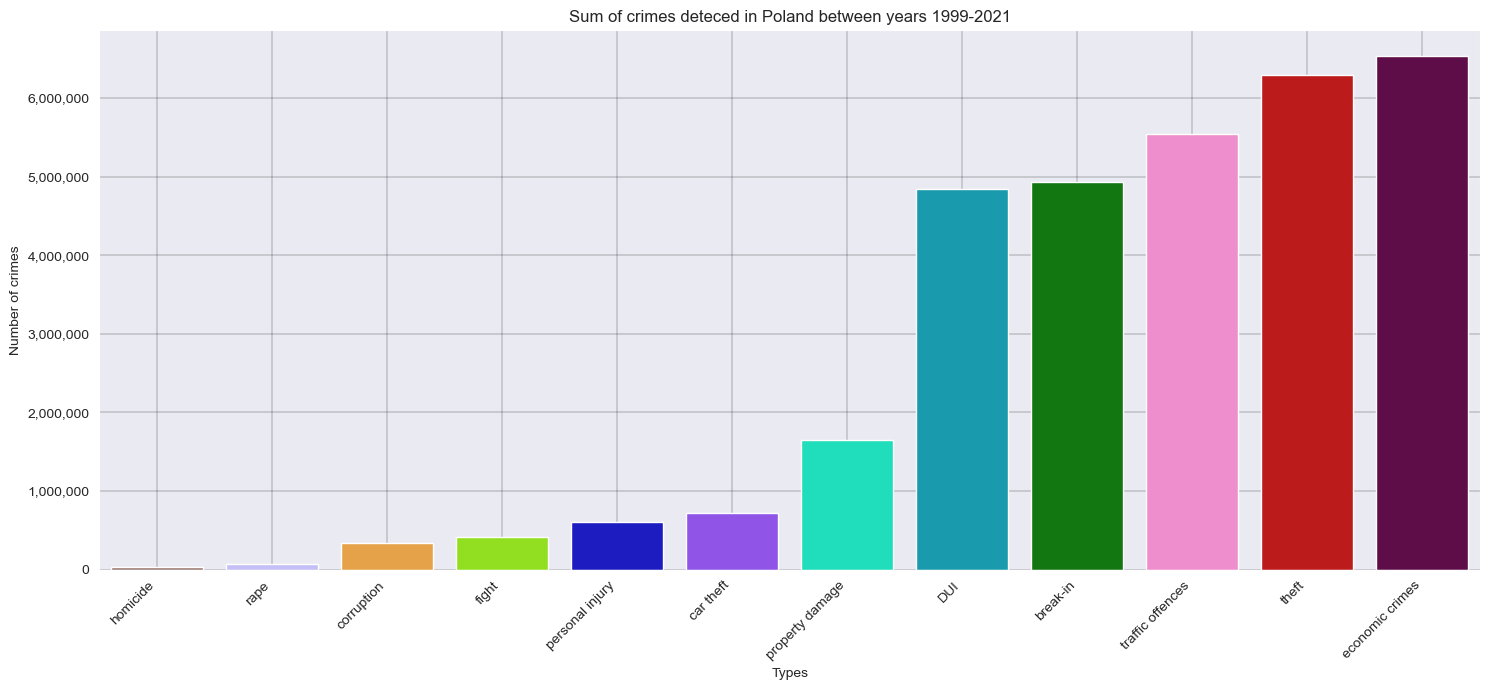

In [10]:
label_format = '{:,}'  # format for thousand separator

sum_country_crimes = country_crimes.groupby('type')['crimes_total'].sum().sort_values().to_frame().reset_index()

plt.subplots(figsize=(15, 7))

ax_country = sns.barplot(data=sum_country_crimes, x="type", y="crimes_total", palette=palette)
ax_country.set_xticklabels(ax_country.get_xticklabels(), rotation=45, ha="right")
ax_country.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: label_format.format(int(x))))

plt.title("Sum of crimes deteced in Poland between years 1999-2021")
plt.xlabel("Types")
plt.ylabel("Number of crimes")
plt.tight_layout()
plt.grid(color='k', linewidth=0.2)
plt.savefig(viz_path+'Barchart_poland_crimes.png')
plt.show()


The chart shows that the most common offences in Poland are economic crimes, theft and traffic offences. Such a substantial number of common thefts in the country may indicate that people need more means to live in decent conditions or are short of life growth opportunities.

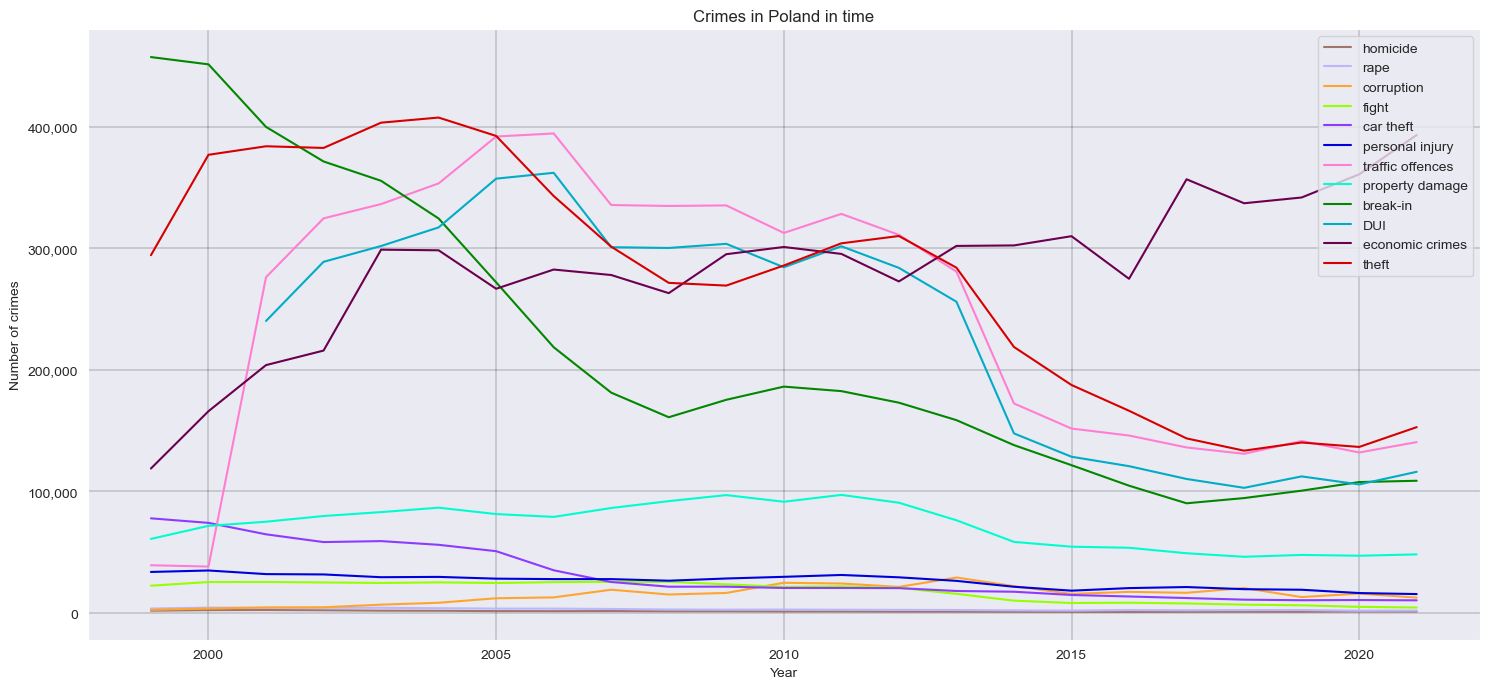

In [11]:
"""
Plotting changes in the amount of all types of crime over time
"""

plt.subplots(figsize=(15, 7))
country_crimes_in_time = country_crimes.groupby(['type', 'year'])[
    'crimes_total'].sum().sort_values().to_frame().reset_index()
ax_poland_time = sns.lineplot(data=country_crimes_in_time, x="year", y="crimes_total", hue="type", legend="auto",
                              palette=palette)
ax_poland_time.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: label_format.format(int(x))))

plt.legend(loc='best')
plt.title("Crimes in Poland in time")
plt.xlabel("Year")
plt.ylabel("Number of crimes")
plt.tight_layout()
plt.grid(color='k', linewidth=0.2)
plt.savefig(viz_path+'Linechart_poland_crimes.png')
plt.show()

Looking at the time chart, the overall number of each crimes other than economic is decreasing. This is positive information for the personal security situation in the country. Fewer crimes, especially violent crimes, the safer it is to live peacefully.
According to Polish law, cyber crimes are also qualified as economic [(source)](https://radkiewicz.net.pl/przestepstwa-gospodarcze/). This could point towards why economic crimes on the chart are going up, as stealing someone's data for extorsion etc., is a common problem in the digitised world.
The bottom lines of less common offences are hard to differentiate on the chart, so to see changes more precisely, below is a chart for the crimes that happened less than 50 000 times in a year.

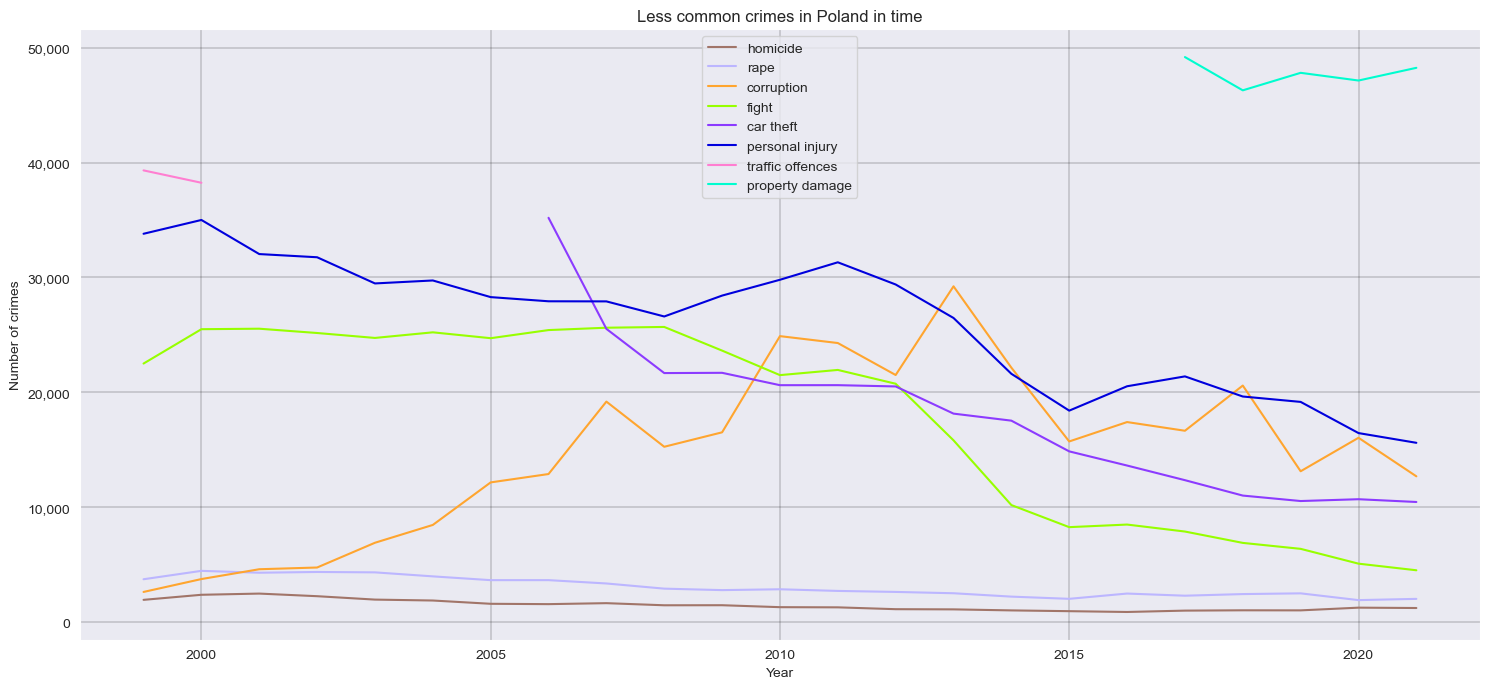

In [12]:
"""
Plot as above but for less common crimes
"""
plt.subplots(figsize=(15, 7))
less_common_crimes_in_time = country_crimes_in_time[country_crimes_in_time["crimes_total"] < 50000]
ax_poland_time = sns.lineplot(data=less_common_crimes_in_time, x="year", y="crimes_total", hue="type", legend="auto",
                              palette=palette)
ax_poland_time.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: label_format.format(int(x))))

plt.legend(loc='best')
plt.title("Less common crimes in Poland in time")
plt.xlabel("Year")
plt.ylabel("Number of crimes")
plt.tight_layout()
plt.grid(color='k', linewidth=0.2)
plt.show()

Most crimes here are also decreasing in volume, which is desired. Some types are present on only part of the diagram here. This is because more or of them started to be detected or the crime became less common, for example, by the justice system's actions (see property damage on the chart).

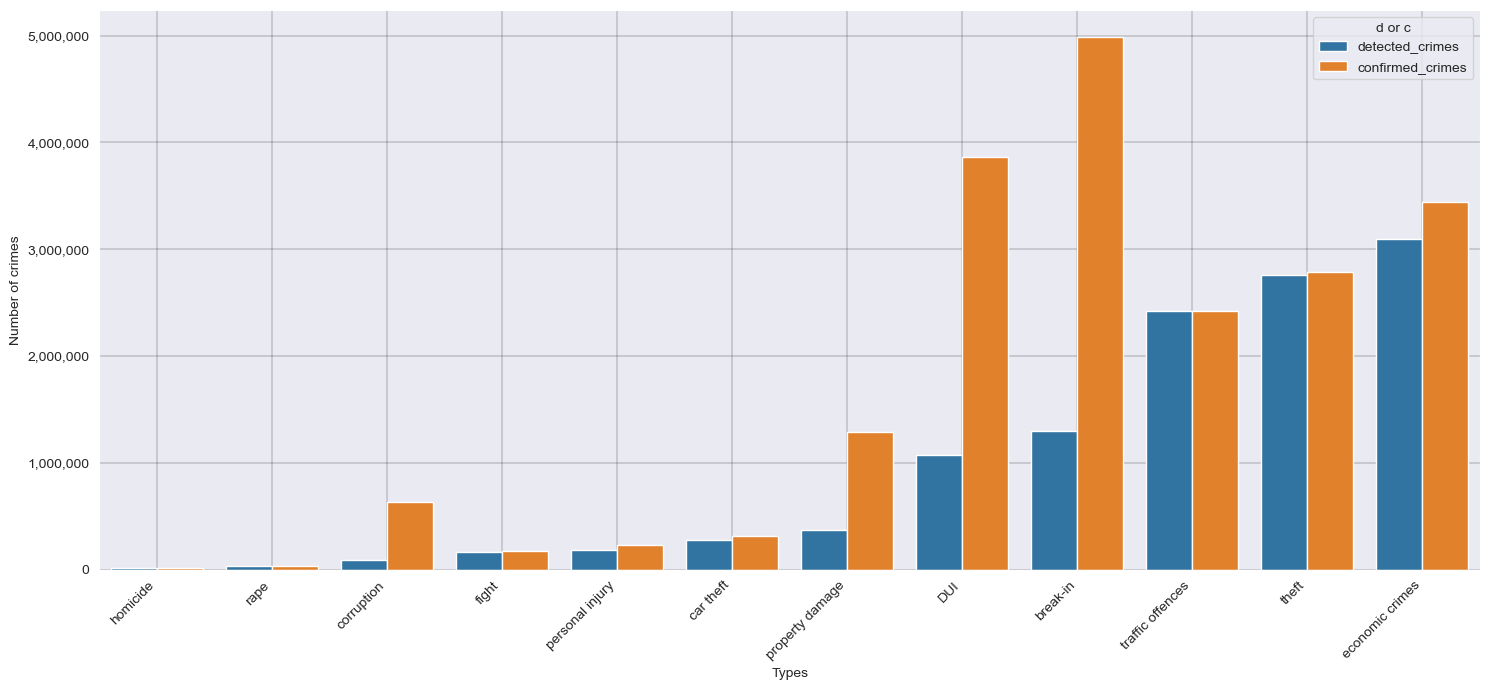

In [13]:
deteced_v_established = country_crimes.melt(id_vars=("type", "year", "area", "crimes_total"), var_name="d or c",
                                            value_name="Number")
sum_d_or_e = deteced_v_established.groupby(['type', 'd or c'])["Number"].sum().sort_values().to_frame().reset_index()

plt.subplots(figsize=(15, 7))
ax_d_or_e = sns.barplot(data=sum_d_or_e, x="type", y="Number", hue="d or c")
ax_d_or_e.set_xticklabels(ax_country.get_xticklabels(), rotation=45, ha="right")
ax_d_or_e.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: label_format.format(int(x))))
plt.xlabel("Types")
plt.ylabel("Number of crimes")
plt.tight_layout()
plt.grid(color='k', linewidth=0.2)

Comparing the number of crimes detected and confirmed for each category shows the effectiveness of the Polish police and court system in bringing criminals to justice. In a preferable situation, there should be more crimes detected than confirmed.
One of the safety measures is the offenders' detection rate, calculated as the ratio of detected crimes to the sum of detected and confirmed crimes. The measure is calculated and plotted below (shown in %)

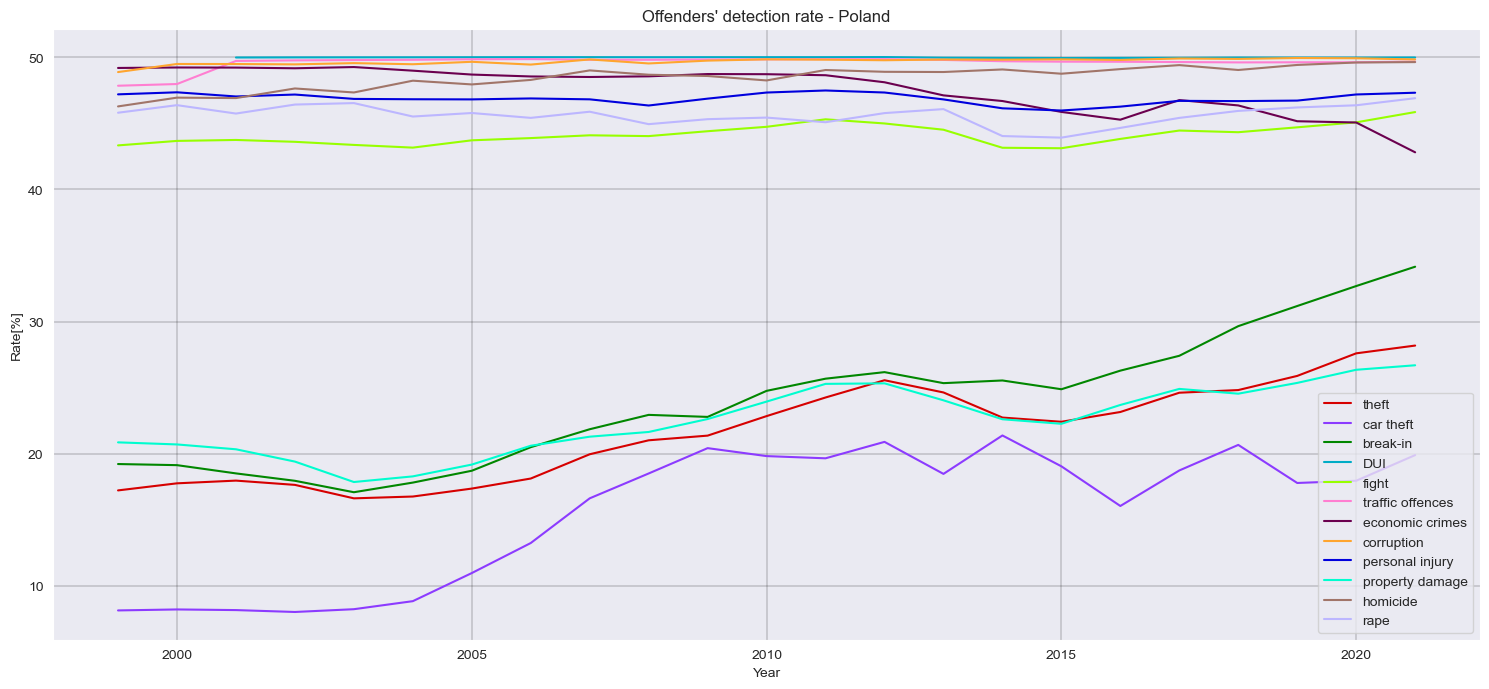

In [14]:
"""
Offenders' detection rate + plot
"""
country_crimes["off_det_rate"] = (country_crimes["detected_crimes"] /
                                  country_crimes["crimes_total"]) * 100  # measure for the overall data
plt.subplots(figsize=(15, 7))
sns.lineplot(data=country_crimes, x="year", y="off_det_rate", hue="type", legend="auto",
             palette=palette)

plt.legend(loc='best')
plt.title("Offenders' detection rate - Poland")
plt.xlabel("Year")
plt.ylabel("Rate[%]")
plt.tight_layout()
plt.grid(color='k', linewidth=0.2)
plt.show()

The rate is increasing or stays roughly the same. The most significant difference can be seen in detecting car theft. As technology progress, it can be easier to find such criminals.

## Crimes in Warsaw

This part compares safety in the country to the security in its capital city.

In [15]:
warsaw_crimes = crimes[crimes['area']=='Warsaw']
warsaw_crimes.reset_index(inplace=True, drop=True)
warsaw_crimes.head()

,area,year,confirmed_crimes,detected_crimes,type,crimes_total
0,Warsaw,2021,18642,4258,theft,22900
1,Warsaw,2020,15954,3550,theft,19504
2,Warsaw,2019,18706,3976,theft,22682
3,Warsaw,2018,17386,3738,theft,21124
4,Warsaw,2017,17441,3608,theft,21049


First, the total sum of each crime for Warsaw is visualised to show which most common offences.

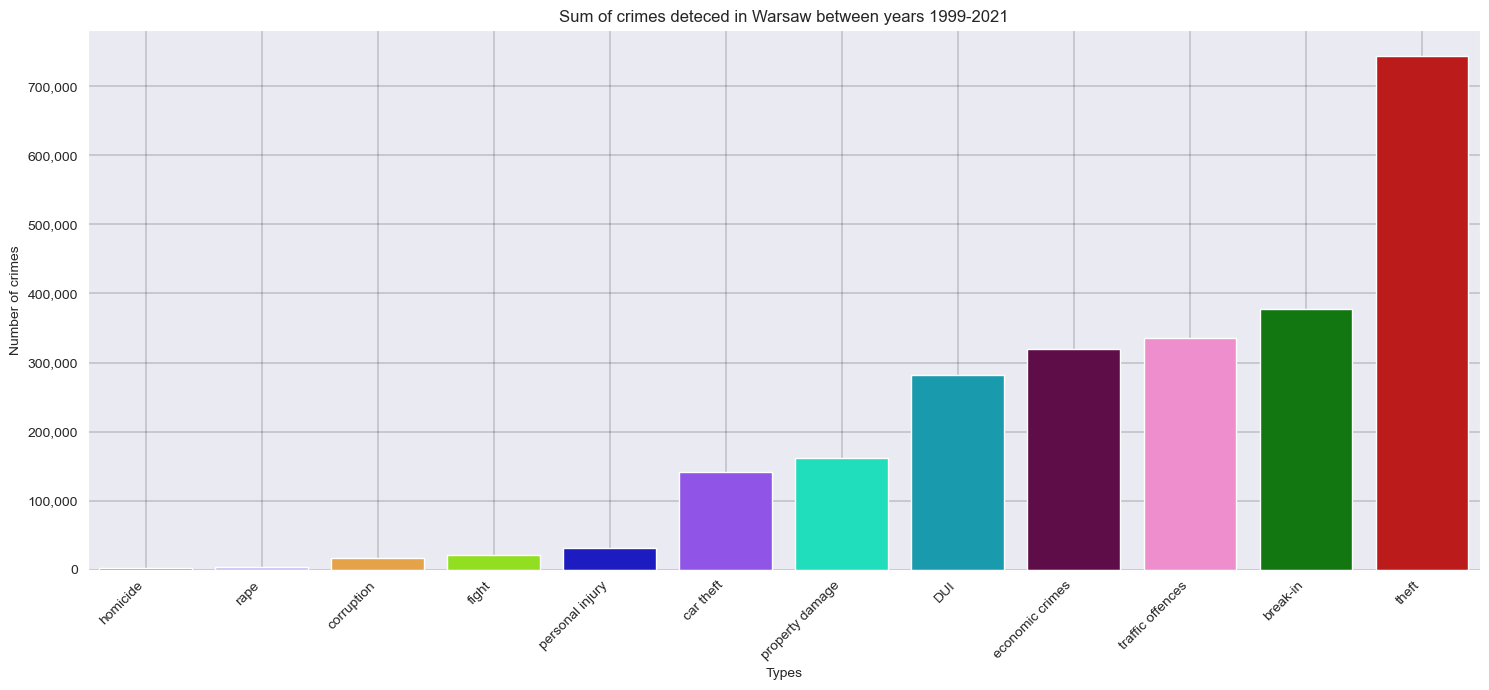

In [16]:
"""
Printing chart with total sum for each crime type
"""

sum_warsaw_crime = warsaw_crimes.groupby('type')['crimes_total'].sum().sort_values().to_frame().reset_index()

plt.subplots(figsize=(15, 7))

ax_country = sns.barplot(data=sum_warsaw_crime, x="type", y="crimes_total", palette=palette)
ax_country.set_xticklabels(ax_country.get_xticklabels(), rotation=45, ha="right")
ax_country.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: label_format.format(int(x))))

plt.title("Sum of crimes deteced in Warsaw between years 1999-2021")
plt.xlabel("Types")
plt.ylabel("Number of crimes")
plt.tight_layout()
plt.grid(color='k', linewidth=0.2)
plt.show()

![image](./src/visualization/Barchart_poland_crimes.png)

Comparing the two charts, the most significant difference is in the top 4 crimes. Warsaw has a much higher theft rate than other crimes, and the order of the top 4 crimes differs. This may be related to the fact that there are more opportunities to steal valuable items in Warsaw. Thieves and burglars have more concentrated possible targets in the big, wealthy city compared to the entire country.

The following chart shows changes in the occurance of each crime type in time.

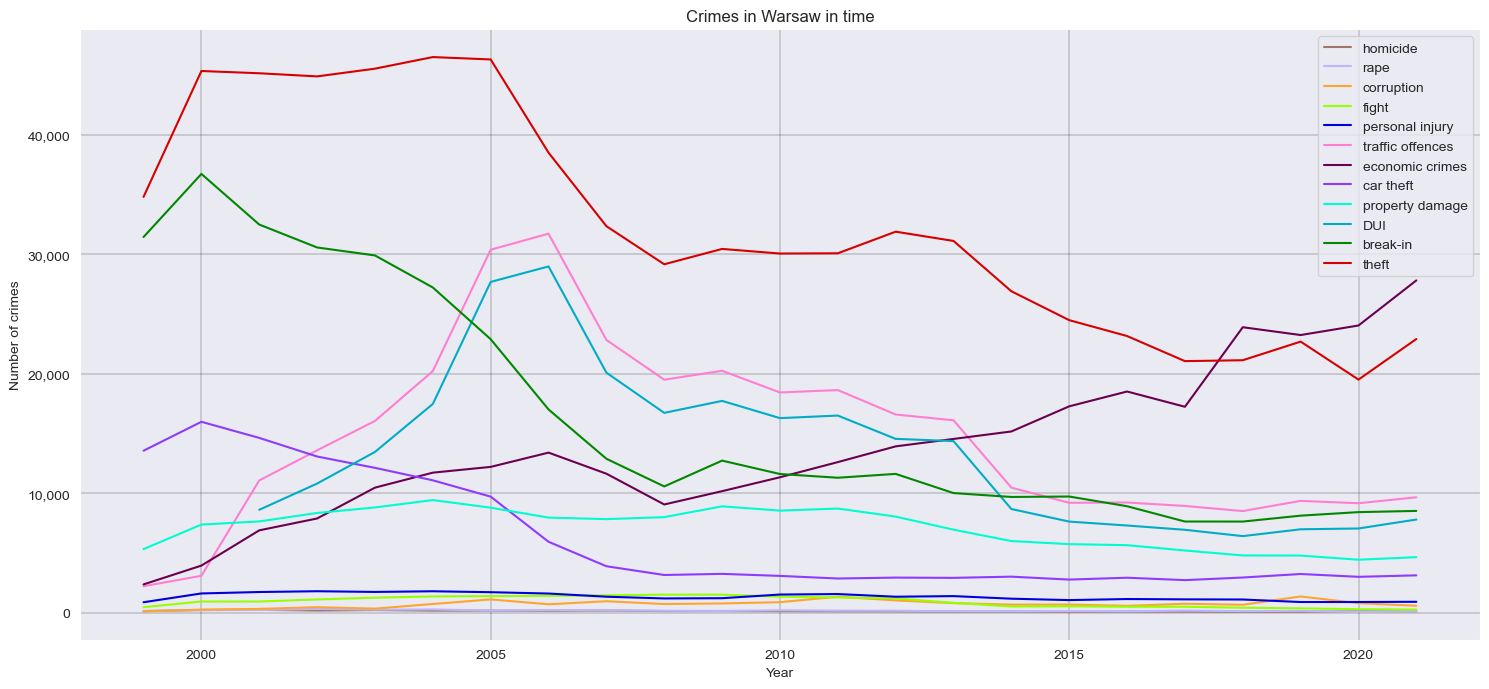

In [17]:
"""
Changes in the number of crimes per year broken down by type
"""

plt.subplots(figsize=(15, 7))
warsaw_crimes_in_time = warsaw_crimes.groupby(['type', 'year'])[
    'crimes_total'].sum().sort_values().to_frame().reset_index()
ax_warsaw_time = sns.lineplot(data=warsaw_crimes_in_time, x="year", y="crimes_total", hue="type", legend="auto",
                              palette=palette)
ax_warsaw_time.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: label_format.format(int(x))))

plt.legend(loc='best')
plt.title("Crimes in Warsaw in time")
plt.xlabel("Year")
plt.ylabel("Number of crimes")
plt.tight_layout()
plt.grid(color='k', linewidth=0.2)

![image](./src/visualization/Linechart_poland_crimes.png)

## Offenders' detection rate

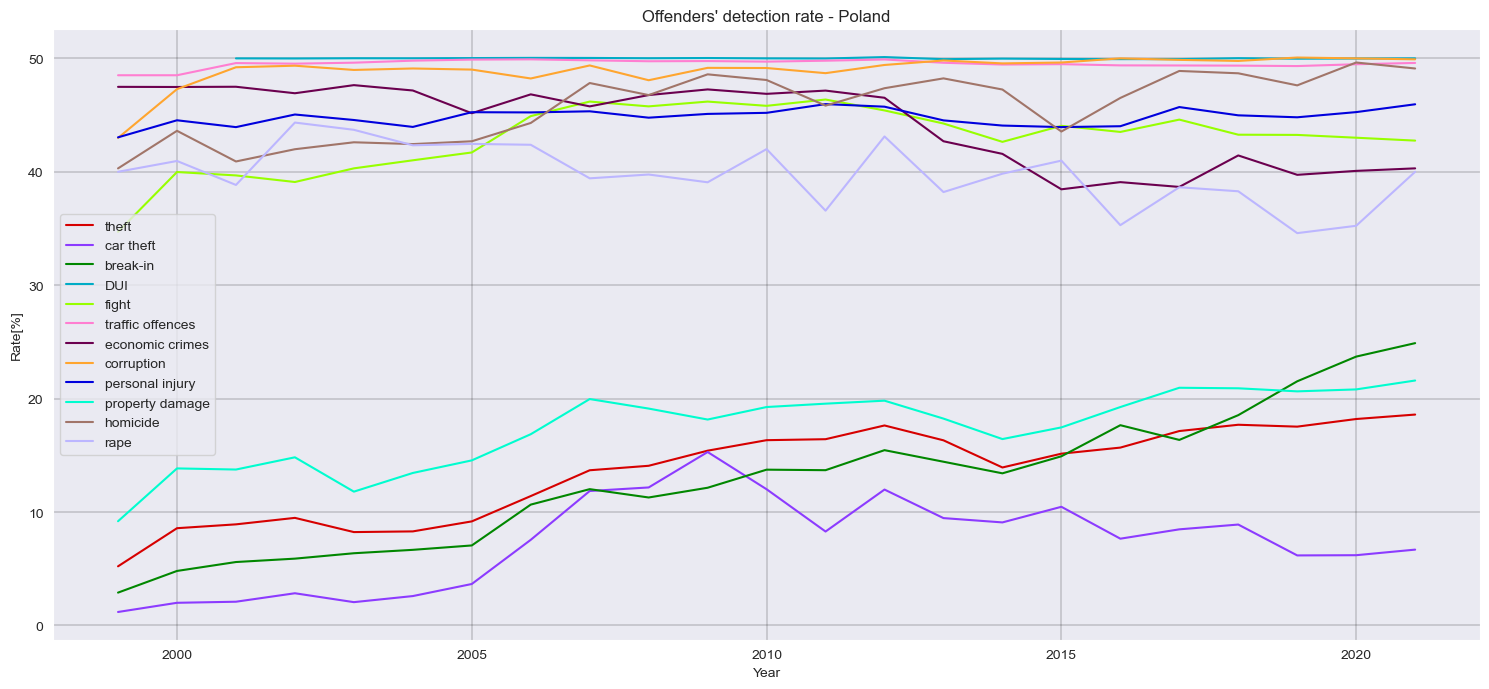

In [18]:
warsaw_crimes["off_det_rate"] = (warsaw_crimes["detected_crimes"] /
                                 warsaw_crimes["crimes_total"]) * 100
plt.subplots(figsize=(15, 7))
sns.lineplot(data=warsaw_crimes, x="year", y="off_det_rate", hue="type", legend="auto",
             palette=palette)

plt.legend(loc='best')
plt.title("Offenders' detection rate - Poland")
plt.xlabel("Year")
plt.ylabel("Rate[%]")
plt.tight_layout()
plt.grid(color='k', linewidth=0.2)
plt.show()

The detection rate looks similar to the previous one on country data. The Police are working with equal efficiency on average.

Offenders' detection rate comparison for Polish regions:

In [19]:
grouped_crimes = crimes.groupby("area")[["detected_crimes", "crimes_total"]].sum().reset_index()
grouped_crimes["off_det_rate"] = grouped_crimes["detected_crimes"] / grouped_crimes["crimes_total"] * 100
grouped_crimes = grouped_crimes.sort_values("off_det_rate")
grouped_crimes

,area,detected_crimes,crimes_total,off_det_rate
2,Warsaw,644964,2437217,26.463134
7,mazowieckie,1378122,4294802,32.088138
16,łódzkie,705848,2038636,34.623542
17,śląskie,1492404,4224605,35.326474
12,pomorskie,761764,2156054,35.331397
8,małopolskie,847687,2384070,35.556297
0,Poland,11784170,31979281,36.849390
15,zachodniopomorskie,600143,1619014,37.068426
3,dolnośląskie,1115773,3006142,37.116444
4,kujawsko-pomorskie,656398,1742343,37.673294


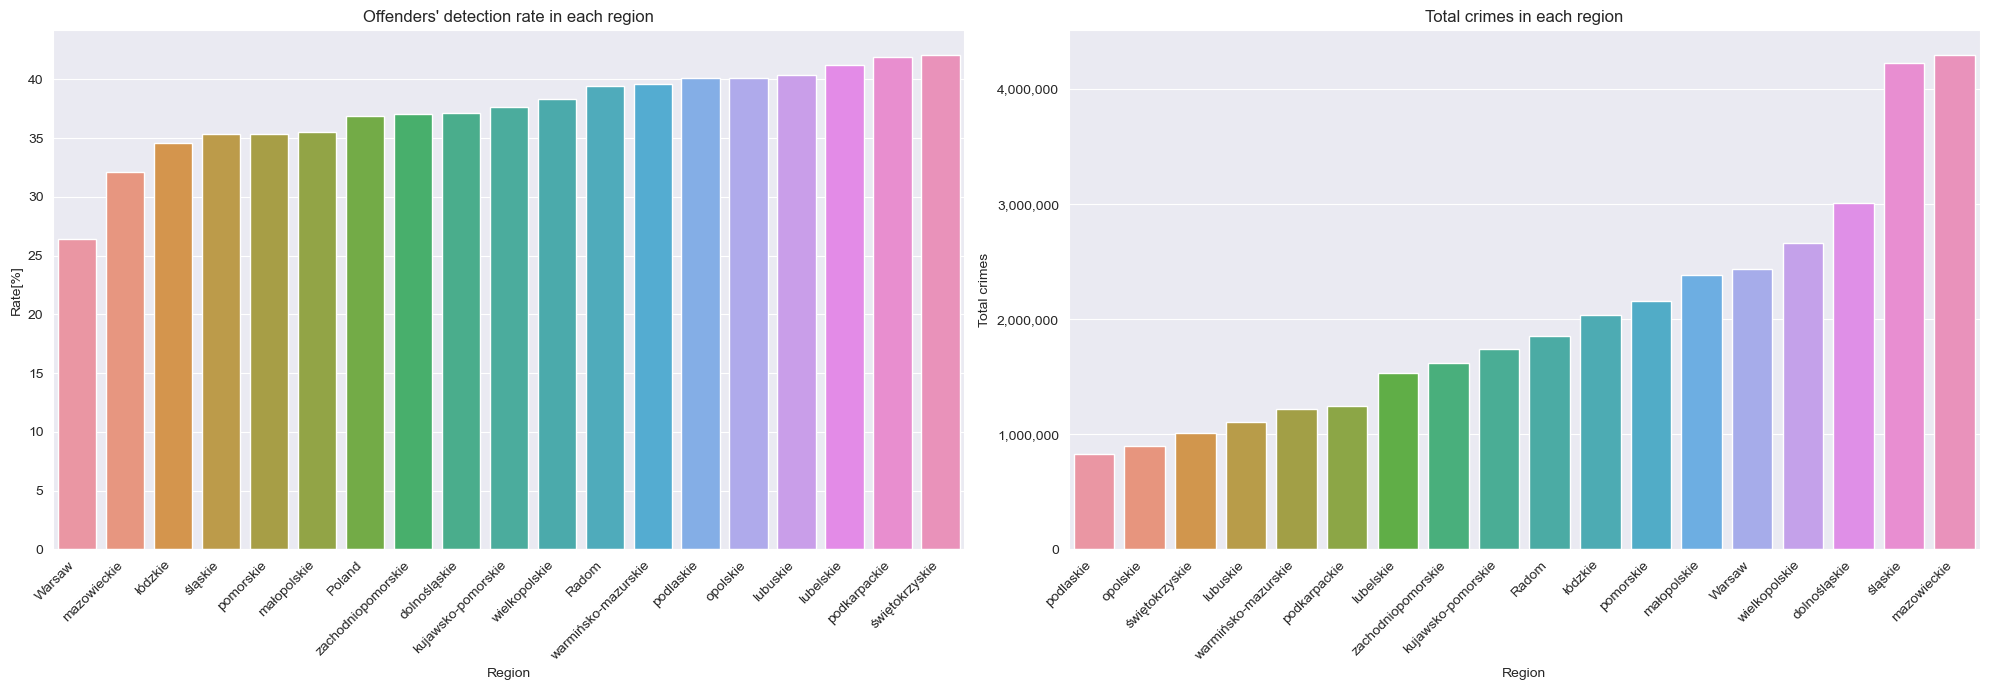

In [20]:
"""
Plotting two charts one with offenders' detection rate and the other with total crimes in each region
"""
_, comp_ax = plt.subplots(ncols=2, figsize=(20, 7))

ax_off_rate = sns.barplot(data=grouped_crimes, x="area", y="off_det_rate", ax=comp_ax[0])
ax_off_rate.set_xticklabels(ax_off_rate.get_xticklabels(), rotation=45, ha="right")
ax_off_rate.title.set_text("Offenders' detection rate in each region")
ax_off_rate.set_xlabel("Region")
ax_off_rate.set_ylabel("Rate[%]")

grouped_total = grouped_crimes[grouped_crimes["area"] != "Poland"]
ax_total_crimes = sns.barplot(data=grouped_total.sort_values("crimes_total"), x="area", y="crimes_total", ax=comp_ax[1])
ax_total_crimes.title.set_text("Total crimes in each region")
ax_total_crimes.set_xlabel("Region")
ax_total_crimes.set_ylabel("Total crimes")
ax_total_crimes.set_xticklabels(ax_total_crimes.get_xticklabels(), rotation=45, ha="right")
ax_total_crimes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: label_format.format(int(x))))

plt.tight_layout()

plt.show()

With the highest offenders detection rate and one of the lowest total crimes count, Świętokrzyskie voivodeship seems to have the most efficiently working police force in the country.

## Summary

### Quick conclusion

- Poland has a low rate of violent crimes but struggles with economic crimes, DUI and thefts
- Offenders' detection rate can be low in some cases. The justice system should work more efficiently
- The analysis could be improved by adding other police data, for example, police personnel records or other publicly available datasets.
- Considering that around 38 million people live in Poland, crime statistics indicate that the country is safe to live in but better to keep belongings secured.
- ...

### Todo list for further analysis

- expand conclusions everywhere in report
- add new data (mentioned in conclusion)
- geospatial charts for visualising differences between voivodeships
- ...